# BANCO AMARILLO - Modelo de Clasificación

# 1. Import & Install

In [1]:
#! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [2]:
#!pip install scikit-learn==0.23.1

In [719]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.optimize as opt

In [720]:
dftrain = pd.read_csv(r'base_train.csv', delimiter = '|')
dfvalidacion = pd.read_csv(r'base_validacion.csv', delimiter = '|')
dfprueba = pd.read_csv(r'base_prueba.csv', delimiter = '|')

In [576]:
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 25)

# 2. Exploratory Data Analysis (EDA)

## 2.1. Comprensión de los Datos

***
- 28,276 para entrenar.
- 2,068 para validar.
- 5,889 para aplicar el modelo.
- Las variables son de tipo: decimal (25), entero (2), texto (1).
- 27 variables independientes.
- 01 variable dependiente: default.
***
- dftrain = Dataset por ID o numdoc, y fecha de desembolsos del 2018. Para entrenamiento.
- dfvalidacion = Dataset por ID o numdoc, y fecha de desembolsos del 2019-01. Para validación del modelo predictivo.
- dfprueba = Dataset por ID o numdoc, y fecha de desembolsos del 2019-02. Para prueba, no tiene variable dependiente.
***

In [176]:
from pandas_profiling import ProfileReport
profile = ProfileReport(dftrain)
profile.to_file("EDA - Banco Amarillo.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [467]:
print(f'n_train =', dftrain.shape)
print(f'n_validacion =', dfvalidacion.shape)
print(f'n_prueba =', dfprueba.shape)

n_train = (28276, 28)
n_validacion = (2068, 28)
n_prueba = (5889, 27)


In [495]:
dftrain.sample(5)

,num_doc,f_analisis,default,tipo_cliente,trx39,trx102,trx106,trx143,trx158,disp309,CO01END010RO,CO01ACP017CC,...,CO02END015CC,CO01END002RO,CO01END086RO,CO01END094RO,CO02NUM086AH,CO02NUM043RO,CO01EXP002AH,CO01NUM002AH,CO01END051RO,CO01ACP011RO,CO02MOR092TO,CO01MOR098RO
23639,246268632604,201802,0,adicion,0,0,0,0,0,8,-3,-1,...,-1,2,102,4,50,50,4,3,4,2,100,99
811,1451506120,201806,0,adicion,1,0,0,0,0,12,1,-2,...,29,0,0,1,40,0,3,4,0,-2,100,99
19983,654811095016,201810,0,objetivo,0,0,0,0,0,7,3,14,...,-2,1,87,6,17,33,12,2,2,2,100,100
8793,366166068726,201811,0,objetivo,2,0,0,0,1,8,0,36,...,0,0,97,0,44,0,5,4,0,-2,68,100
2346,891491402158,201812,0,adicion,1,0,0,0,0,7,1,-2,...,-4,2,57,4,25,0,3,2,3,-2,100,100


**Otros Calculos**

In [644]:
dfvalidacion.shape[0]/(dftrain.shape[0]+dfvalidacion.shape[0])

0.07368083514447572

In [446]:
#¿Se tienen registro de los ultimos meses del 2017?
#dftrain[['f_analisis', 'CO01END086RO']].loc[1000:1005]
grp = dftrain.groupby(['f_analisis'])
grp.get_group(201801)['CO01END086RO'].count()

890

In [250]:
# Diccionario dice que es porcentaje, pero sus valores exceden 1.
dftrain.nlargest(5, 'CO02EXP011TO')['CO02EXP011TO']

1    -1
14   -1
16   -1
18   -1
29   -1
Name: CO02NUM043RO, dtype: float64

In [22]:
print(
    'Cantidad de observaciones que están por encima de un cien numérico en la variable CO02EXP011TO:', 
    (dftrain['CO02EXP011TO'] > 100).sum(), 
    '. Y ocurre', 
    (dftrain['CO02END015CC'] > 100).sum(), 
    'veces con la variable CO02END015CC. Por otro lado, la variable supuesta a ser porcentual CO02NUM043RO no excede el número 100, pero tiene', 
    (dftrain['CO02NUM043RO'] < 0).sum(), 
    'valores negativos.')

Cantidad de observaciones que están por encima de un cien numérico en la variable CO02EXP011TO: 672 . Y ocurre 22 veces con la variable CO02END015CC. Por otro lado, la variable supuesta a ser porcentual CO02NUM043RO no excede el número 100, pero tiene 6514 valores negativos.


In [141]:
dftrain['CO02NUM043RO'].sample(5)

24086    89.47
16411    58.33
17520    -1.00
1682     16.67
2265     33.33
Name: CO02NUM043RO, dtype: float64

## 2.2 Preparación de Datos

**Transformación**

In [721]:
variables = {
    'CO01ACP011RO': 'n_cancelaciones_positivas (RO)',
    'CO01ACP017CC': 'ultima_cancelacion_positiva_m (CC)',
    'CO01END002RO': 'saldo_promedio_hist (RO)',
    'CO01END010RO': 'cupo_promedio_hist (RO)',
    'CO01END051RO': 'saldo_total_9m (RO)',
    'CO01END086RO': 'frecuencia_uso_3m (RO)',
    'CO01END094RO': 'cupo_maximo_hist (RO)',
    'CO01EXP001CC': 'antiguedad_apertura (CC)',
    'CO01EXP002AH': 'recencia_apertura (AH)',
    'CO01EXP003RO': 'antiguedad_apertura (RO)',
    'CO01MOR098RO': 'ponderacion_reportes_positivo_24m (RO)',
    'CO01NUM002AH': 'cantidad_cta_ahorro (AH)',
    'CO02END015CC': '%_cartera_vencida (CC)',
    'CO02EXP004TO': 'recencia_apertura (TO)',
    'CO02EXP011TO': '%_antiguedad_>48m (TO)',
    'CO02MOR092TO': 'ponderacion_reportes_positivo_18m (TO)',
    'CO02NUM043RO': '%_cierre_del_total (RO)',
    'CO02NUM086AH': 'participacion_ctas_ahorro (TO)',
    'disp309': 'os_cel',
    'trx102': 'monto_min_transado_1m (TO)',
    'trx106': 'monto_min_transado_2m (TO)',
    'trx143': 'sd_monto_recarga_12m (TO)',
    'trx158': 'retiro_monto_promedio_12m (AH)',
    'trx39': 'sd_cantidad_retiros_12m (AH)',
    'num_doc': 'num_doc',
    'f_analisis': 'f_analisis',
    'default': 'default',
    'tipo_cliente': 'tipo_cliente'}

dftrain = dftrain.rename(columns=variables)
dfvalidacion = dfvalidacion.rename(columns=variables)
dfprueba = dfprueba.rename(columns=variables)



In [722]:
dftrain['num_doc'] = dftrain['num_doc'].map('{:.0f}'.format)
dfvalidacion['num_doc'] = dfvalidacion['num_doc'].map('{:.0f}'.format)
dfprueba['num_doc'] = dfprueba['num_doc'].map('{:.0f}'.format)
dftrain['f_analisis'] = pd.to_datetime(dftrain['f_analisis'], format='%Y%m')
dfvalidacion['f_analisis'] = pd.to_datetime(dfvalidacion['f_analisis'], format='%Y%m')
dfprueba['f_analisis'] = pd.to_datetime(dfprueba['f_analisis'], format='%Y%m')

**Datos Faltantes**

In [5]:
m_values = dftrain.isnull().sum().sum() + dfvalidacion.isnull().sum().sum() + dfprueba.isnull().sum().sum()
print(r'Valores faltantes de los conjuntos de datos:', m_values)

Valores faltantes de los conjuntos de datos: 0


**Datos Duplicados**

In [368]:
d_values = dftrain['num_doc'].duplicated().sum() + dfvalidacion['num_doc'].duplicated().sum() + dfprueba['num_doc'].duplicated().sum()
print(r'Valores duplicados por ID en los conjuntos de datos:', d_values)

Valores duplicados por ID en los conjuntos de datos: 2277


In [579]:
df1_df2 = pd.concat([dftrain, dfvalidacion], ignore_index=True)

porcentaje_duplicados = (df1_df2['num_doc'].duplicated().sum()/df1_df2.shape[0])*100
clientes_unicos = dftrain['num_doc'].nunique()
datos_duplicados = df1_df2['num_doc'].duplicated().sum()
print('Se tienen en total', datos_duplicados, 'observaciones duplicadas entre el conjunto de entrenamiento y el conjunto de validacion', round(porcentaje_duplicados), '% de las observaciones en dataset de entrenamiento y validación. Y los valores de ID únicos con los que cuentan el dataset de entrenamiento es:', clientes_unicos, 'de', dftrain.shape[0], 'datos.')

Se tienen en total 2636 observaciones duplicadas entre el conjunto de entrenamiento y el conjunto de validacion 9 % de las observaciones en dataset de entrenamiento y validación. Y los valores de ID únicos con los que cuentan el dataset de entrenamiento es: 25999 de 28276 datos.


In [580]:
pd.set_option('display.float_format', '{:.0f}'.format)
dftrain_count_duplicates = dftrain['num_doc'].value_counts()
dftrain_count_duplicates.head(5)

115666148254    5
148576532839    5
97045735146     4
961788902240    4
377442457426    4
Name: num_doc, dtype: int64

In [581]:
dftrain[(dftrain['num_doc'] == '683794793162')][['num_doc', 'default']]

,num_doc,default
13590,683794793162,0
22308,683794793162,0
23556,683794793162,1
26112,683794793162,0


In [723]:
dftrain_sorted = dftrain.sort_values(by='default', ascending=False)
dftrain = dftrain_sorted.drop_duplicates(subset=['num_doc'], keep='first')
dftrain.sort_index(inplace=True)
print(r'quedan', dftrain.shape[0], r'clientes unicos')


quedan 25999 clientes unicos


C:\Users\manue\AppData\Local\Temp\ipykernel_25148\2656024762.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftrain.sort_index(inplace=True)


In [373]:
dftrain.loc[dftrain['num_doc'] == '683794793162'][['num_doc', 'default']]

,num_doc,default
23556,683794793162,1


**Outliers**

In [748]:
pd.reset_option('display.float_format')
dftrain.columns

Index(['num_doc', 'f_analisis', 'default', 'tipo_cliente',
       'sd_cantidad_retiros_12m (AH)', 'monto_min_transado_1m (TO)',
       'monto_min_transado_2m (TO)', 'sd_monto_recarga_12m (TO)',
       'retiro_monto_promedio_12m (AH)', 'os_cel', 'cupo_promedio_hist (RO)',
       'ultima_cancelacion_positiva_m (CC)', '%_antiguedad_>48m (TO)',
       'recencia_apertura (TO)', 'antiguedad_apertura (CC)',
       'antiguedad_apertura (RO)', '%_cartera_vencida (CC)',
       'saldo_promedio_hist (RO)', 'frecuencia_uso_3m (RO)',
       'cupo_maximo_hist (RO)', 'participacion_ctas_ahorro (TO)',
       '%_cierre_del_total (RO)', 'recencia_apertura (AH)',
       'cantidad_cta_ahorro (AH)', 'saldo_total_9m (RO)',
       'n_cancelaciones_positivas (RO)',
       'ponderacion_reportes_positivo_18m (TO)',
       'ponderacion_reportes_positivo_24m (RO)'],
      dtype='object')

<AxesSubplot: >

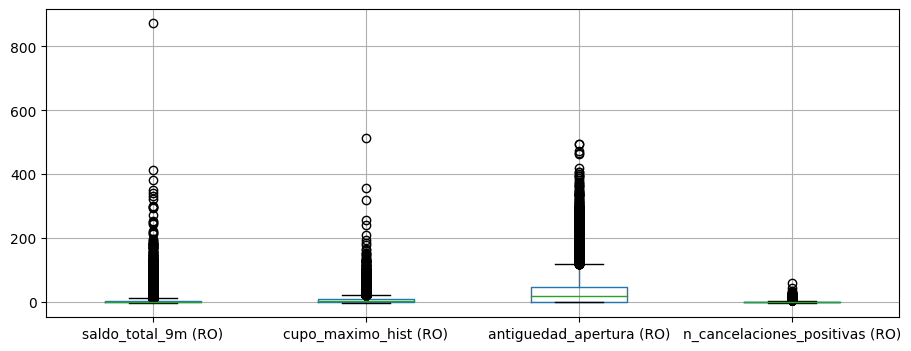

In [749]:
%matplotlib inline
quick_viz_varios = dftrain[['saldo_total_9m (RO)', 'cupo_maximo_hist (RO)', 'antiguedad_apertura (RO)', 'n_cancelaciones_positivas (RO)']]
plt.figure(figsize=(11, 4))
quick_viz_varios.boxplot()

                                                                                            Imagen_01: Variables de Interés

In [374]:
col_analisis = dftrain['saldo_total_9m (RO)']

Q0 = col_analisis.quantile(0)
Q1 = col_analisis.quantile(0.25)
Q2 = col_analisis.quantile(0.50)
Q3 = col_analisis.quantile(0.75)
Q4 = col_analisis.quantile(1)

iqr = Q3 - Q1
sup = Q3 + (3 * iqr)
inf = Q1 - (3 * iqr)
outliers = (col_analisis > sup) | (col_analisis < inf)
q_outliers = outliers.sum()
q_outliers

1730

In [724]:
más_de_2600_outliers = []
entre_1300_2600_outliers = []
menos_de_1300_outliers = []

columnas_especificas = [
    'saldo_total_9m (RO)', 
    'cupo_maximo_hist (RO)', 
    'antiguedad_apertura (RO)', 
    'n_cancelaciones_positivas (RO)']

for columna in dftrain.columns:
    if dftrain[columna].dtype in ['int64', 'float64']:
        setenta_y_cinco = dftrain[columna].quantile(0.75)
        veinticinco = dftrain[columna].quantile(0.25)
        rango_intercuartil = setenta_y_cinco - veinticinco
        limite_superior = setenta_y_cinco + (3 * rango_intercuartil)
        limite_inferior = veinticinco - (3 * rango_intercuartil)
        valores_atipicos = dftrain[(dftrain[columna] < limite_inferior) | (dftrain[columna] > limite_superior)]
        cantidad_valores_atipicos = valores_atipicos.shape[0]      
        
        if cantidad_valores_atipicos >= 2600:
            más_de_2600_outliers.append(columna)
        elif 1300 < cantidad_valores_atipicos < 2600:
            entre_1300_2600_outliers.append(columna)
        elif cantidad_valores_atipicos <= 1300:
            menos_de_1300_outliers.append(columna)
            
        if columna in columnas_especificas:
            dftrain = dftrain.drop(valores_atipicos.index) 
            
print("Columnas con más de 2,600 valores atípicos - eliminar columna:", más_de_2600_outliers)
print("\n")
print("Columnas con 1300-2599 valores atípicos - revisar y/o eliminar observaciones:", entre_1300_2600_outliers)
print("\n")
print("Columnas con menos de 1300 valores atípicos o menos - revisar:", menos_de_1300_outliers)


Columnas con más de 2,600 valores atípicos - eliminar columna: ['monto_min_transado_1m (TO)', 'monto_min_transado_2m (TO)']


Columnas con 1300-2599 valores atípicos - revisar y/o eliminar observaciones: ['default', 'sd_monto_recarga_12m (TO)', 'retiro_monto_promedio_12m (AH)', 'saldo_total_9m (RO)']


Columnas con menos de 1300 valores atípicos o menos - revisar: ['sd_cantidad_retiros_12m (AH)', 'os_cel', 'cupo_promedio_hist (RO)', 'ultima_cancelacion_positiva_m (CC)', '%_antiguedad_>48m (TO)', 'recencia_apertura (TO)', 'antiguedad_apertura (CC)', 'antiguedad_apertura (RO)', '%_cartera_vencida (CC)', 'saldo_promedio_hist (RO)', 'frecuencia_uso_3m (RO)', 'cupo_maximo_hist (RO)', 'participacion_ctas_ahorro (TO)', '%_cierre_del_total (RO)', 'recencia_apertura (AH)', 'cantidad_cta_ahorro (AH)', 'n_cancelaciones_positivas (RO)', 'ponderacion_reportes_positivo_18m (TO)', 'ponderacion_reportes_positivo_24m (RO)']


In [725]:
dftrain.drop(columns=['monto_min_transado_1m (TO)', 'monto_min_transado_2m (TO)'], inplace=True)
dfvalidacion.drop(columns=['monto_min_transado_1m (TO)', 'monto_min_transado_2m (TO)'], inplace=True)
dftrain.sort_index(inplace=True)

**Otros Cálculos**

<AxesSubplot: >

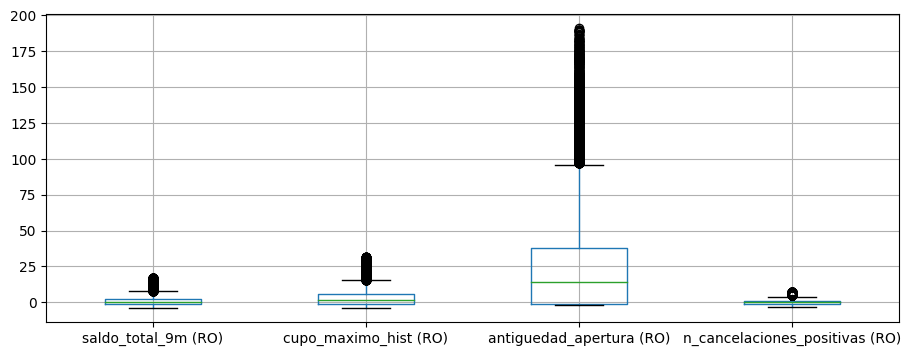

In [756]:
quick_viz_varios = dftrain[['saldo_total_9m (RO)', 'cupo_maximo_hist (RO)', 'antiguedad_apertura (RO)', 'n_cancelaciones_positivas (RO)']]
plt.figure(figsize=(11, 4))
quick_viz_varios.boxplot()

                                                                    Imagen_02: Variables de Interés con reducción de ruido.

## 2.3. Analisis Descriptivo

### 2.3.1. Generalidades

***
- 23,332 clientes unicos. 
- Se reduce el set de entrenamiento en un 17.5% entre duplicados y outliers.
- 25 variables explicativas sobre portafolio de productos: crédito rotativo, telecomunicaciones y ahorro.
***
- Mas de la mitad de los registros pertenece a los ultimos 03 meses del año 2018.
- 77% son del tipo de cliente "Adición".
- 23% son del tipo de cliente "Objetivo".
- 93% de los clientes se encuentran en cumplimiento con el pago de sus obligaciones.

***
*Nota*:
- Hay un desbalance importante en la clase "No Default". Esto lo vamos a tener que considerar durante la fase de modelamiento, ya que el modelo va a buscar reducir el error pronosticando cercano a 0. 

f_analisis
201810    3762
201811    4131
201812    4549
dtype: int64


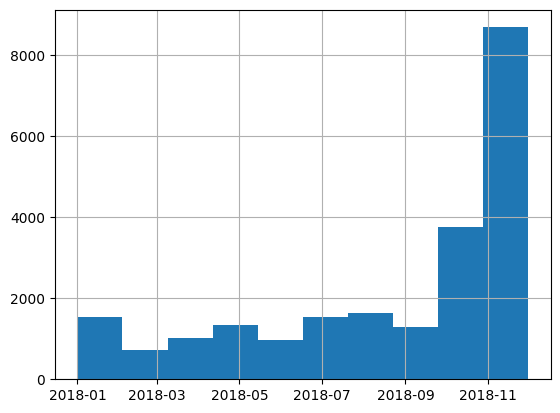

In [794]:
dftrain['f_analisis'].hist()
conteo = dftrain[dftrain['f_analisis'].dt.strftime('%Y%m').isin(['201810', '201811', '201812'])].groupby(dftrain['f_analisis'].dt.strftime('%Y%m')).size()
print(conteo)

In [795]:
da_1 = dftrain['tipo_cliente'].value_counts()
da_2 = dftrain['default'].value_counts(normalize=True)
print(da_1)
print(da_2)

adicion     17303
objetivo     5172
Name: tipo_cliente, dtype: int64
0   1
1   0
Name: default, dtype: float64


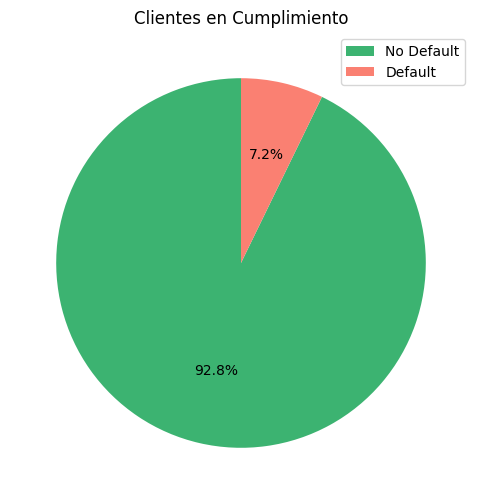

In [796]:
labels = ['No Default', 'Default']
colors = ['mediumseagreen', 'salmon']

plt.figure(figsize=(6, 6))
plt.pie(da_2,  autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Clientes en Cumplimiento')
plt.legend(labels, loc='upper right')
plt.show()

In [781]:
default_grp = dftrain.groupby(['default'])
default_grp.get_group(1).describe()

,default,sd_cantidad_retiros_12m (AH),sd_monto_recarga_12m (TO),retiro_monto_promedio_12m (AH),os_cel,cupo_promedio_hist (RO),ultima_cancelacion_positiva_m (CC),%_antiguedad_>48m (TO),recencia_apertura (TO),antiguedad_apertura (CC),antiguedad_apertura (RO),%_cartera_vencida (CC),saldo_promedio_hist (RO),frecuencia_uso_3m (RO),cupo_maximo_hist (RO),participacion_ctas_ahorro (TO),%_cierre_del_total (RO),recencia_apertura (AH),cantidad_cta_ahorro (AH),saldo_total_9m (RO),n_cancelaciones_positivas (RO),ponderacion_reportes_positivo_18m (TO),ponderacion_reportes_positivo_24m (RO)
count,1668,1668,1668,1668,1668,1668,1668,1668,1668,1668,1668,1668,1668,1668,1668,1668,1668,1668,1668,1668,1668,1668,1668
mean,1,1,0,0,5,-0,10,88,4,40,17,4,1,41,2,46,21,7,2,1,-1,53,29
std,0,1,0,0,4,2,24,23,12,51,28,23,2,62,4,25,32,13,1,4,1,47,44
min,1,0,0,0,0,-3,-3,-2,-2,-1,-2,-4,-4,-4,-3,-3,-1,-1,-1,-4,-2,-3,-3
25%,1,0,0,0,0,-1,-2,80,0,-1,-1,-4,-1,-1,-1,29,-1,2,2,-1,-1,-1,-1
50%,1,0,0,0,7,-1,-1,100,2,20,2,-1,0,0,1,41,0,4,2,-1,-1,76,-1
75%,1,1,0,0,8,0,11,100,4,63,25,0,2,87,3,60,42,9,3,2,0,100,89
max,1,10,3,2,12,15,181,300,294,256,168,292,14,1276,31,100,100,294,10,17,7,100,100


In [782]:
default_grp.get_group(0).describe()

,default,sd_cantidad_retiros_12m (AH),sd_monto_recarga_12m (TO),retiro_monto_promedio_12m (AH),os_cel,cupo_promedio_hist (RO),ultima_cancelacion_positiva_m (CC),%_antiguedad_>48m (TO),recencia_apertura (TO),antiguedad_apertura (CC),antiguedad_apertura (RO),%_cartera_vencida (CC),saldo_promedio_hist (RO),frecuencia_uso_3m (RO),cupo_maximo_hist (RO),participacion_ctas_ahorro (TO),%_cierre_del_total (RO),recencia_apertura (AH),cantidad_cta_ahorro (AH),saldo_total_9m (RO),n_cancelaciones_positivas (RO),ponderacion_reportes_positivo_18m (TO),ponderacion_reportes_positivo_24m (RO)
count,21664,21664,21664,21664,21664,21664,21664,21664,21664,21664,21664,21664,21664,21664,21664,21664,21664,21664,21664,21664,21664,21664,21664
mean,0,1,0,0,7,1,12,81,4,48,26,-1,1,33,4,47,33,8,3,1,-0,71,44
std,0,1,0,0,4,3,26,23,10,55,35,20,2,38,6,24,36,13,1,4,2,44,49
min,0,0,0,0,0,-3,-3,-4,-2,-1,-2,-4,-4,-4,-4,-3,-1,-1,-1,-4,-3,-3,-3
25%,0,0,0,0,6,-1,-1,67,1,-1,-1,-4,-1,-1,-1,30,-1,2,2,-1,-1,0,-2
50%,0,0,0,0,7,0,-1,83,3,30,14,-2,0,19,2,43,25,6,2,0,0,100,-1
75%,0,1,0,0,10,2,15,100,6,75,39,-1,2,62,6,60,67,12,3,3,1,100,100
max,0,13,4,3,12,31,240,650,673,289,191,2098,29,841,32,100,100,673,9,17,7,100,100


In [231]:
dftrain.to_csv(r'dftrain_clean.csv')

### 2.3.2. Correlación

C:\Users\manue\AppData\Local\Temp\ipykernel_25148\550921105.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = dftrain.corr()


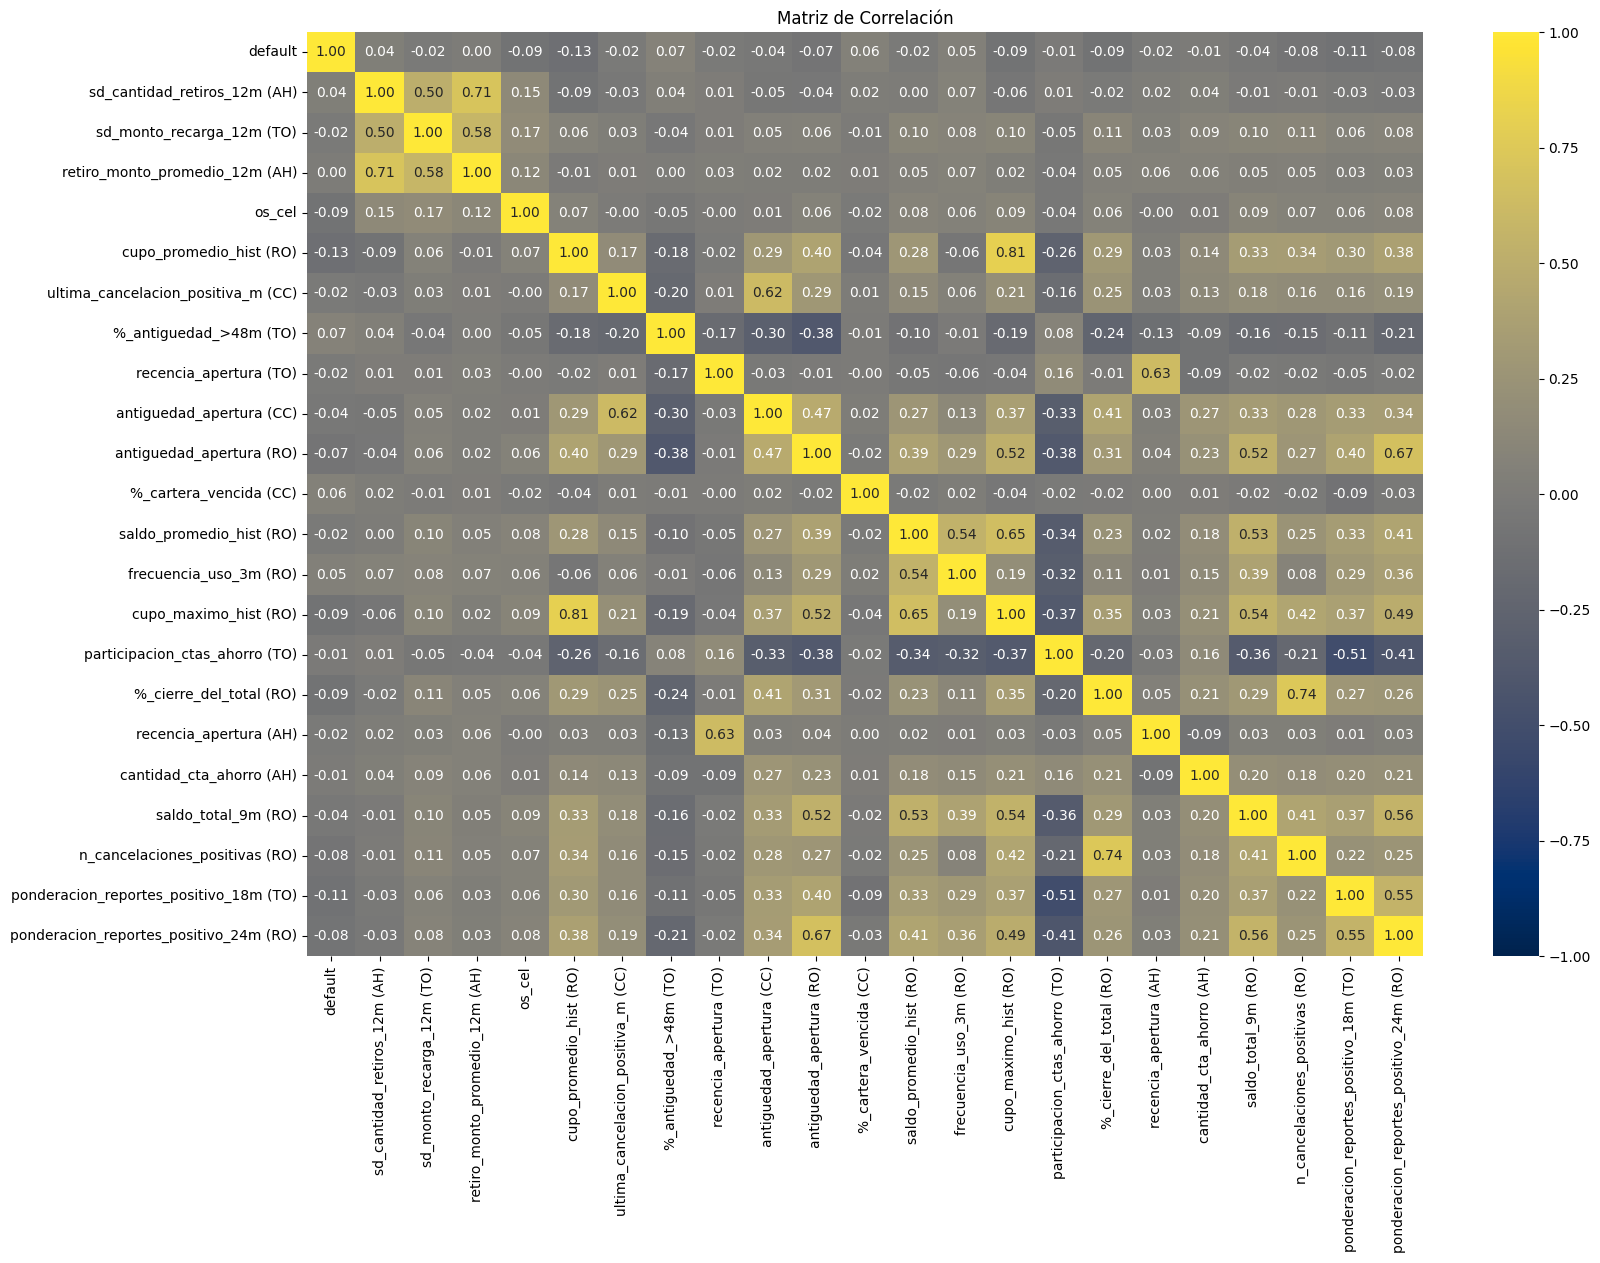

In [377]:
corr = dftrain.corr()
plt.figure(figsize=(18, 12))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="cividis", vmin=-1, vmax=1)
plt.title('Matriz de Correlación')
plt.show()

                                                                                            Imagen_04: Matriz de Correlación

**Producto de Ahorro:**
- sd_cantidad_retiros_12m (AH) tiene una correlación positiva fuerte con retiro_monto_promedio_12m (AH): puede darse a la naturaleza del cálculo de ambas.
***
**Crédito Rotativo:**
- cupo_promedio_hist (RO) tiene una correlación positiva con antiguedad_apertura (RO): lo que me puede indicar que los clientes más antiguos pueden llegar a obtener límites de crédito más altos, o tienen un mejor comportamiento de pago de obligaciones. 
- cupo_promedio_hist(RO) tiene una correlación positiva fuerte con cupo_maximo_hist (RO): los clientes que mantienen un promedio alto para consumo de crédito (sea porque pagan o usan poco), tienen límites de crédito mayor. 
- n_cancelaciones_positivas (RO) tiene una fuerte correlación positiva con %_cierre_del_total (RO): un cliente que realiza más pagos positivos (dentro del plazo y del monto), va a tener un % de cierre del total mayor.
- frecuencia_uso_3m (RO) tiene cierta correlación positiva con antiguedad_apertura (RO): podría indicar que los clientes más antiguos utilizan más sus productos rotativos, sin embargo, la correlación no es lo suficientemente fuerte para inferirlo.
- ponderacion_reportes_positivo_18m (TO) tiene una correlación positiva con antiguedad_apertura (RO): los clientes que tuvieron mayores reportes positivos en 18 meses suelen ser más antiguos. 
- ponderacion_reportes_positivo_24m (RO) tiene una correlación positiva con antiguedad_apertura (RO): Refuerza el punto anterior, en esta, únicamente para portafolio rotativo. 
- ponderacion_reportes_positivo_24m (RO) tiene una correlación positiva con ponderacion_reportes_positivo_18m (TO):  puede explicarse por una proporción considerable de productos rotativos. 
***
**Telcos:**
- ultima_cancelacion_positiva_m (CC) tiene una correlación positiva con antiguedad_apertura (CC): esto me puede indicar que los clientes Telcos más antiguos, han pagado positivamente en su pago más reciente.
***
**Total:**
- recencia_apertura (TO) tiene una correlación positiva con recencia_apertura (AH): podría considerar que los productos de ahorro son mayores en proporción que los otros productos, por ello el producto total aumenta junto con el de ahorro.
***

# 3. Modelo Predictivo

## 3.1 Selección de Variables

In [587]:
pd.reset_option('display.float_format')

In [755]:
train = dftrain.copy()
validacion = dfvalidacion.copy()
prueba = dfprueba.copy()

#por funcionalidad
train.drop(columns=[], inplace=True)
validacion.drop(columns=[], inplace=True)

In [756]:
from scipy.stats import pearsonr

#por p-value
train.drop(columns=['retiro_monto_promedio_12m (AH)', 'cantidad_cta_ahorro (AH)', 'participacion_ctas_ahorro (TO)'], inplace=True)
validacion.drop(columns=['retiro_monto_promedio_12m (AH)', 'cantidad_cta_ahorro (AH)', 'participacion_ctas_ahorro (TO)'], inplace=True)
target_variable = 'default'
results = {}

for column in train.select_dtypes(include=['number']).columns:
    if column != target_variable:
        corr, p_value = pearsonr(train[target_variable], train[column])
        results[column] = {'correlation': corr, 'p_value': p_value}

corr_df = pd.DataFrame(results).T
corr_df.sort_values(by='p_value', inplace=True)
print(corr_df)
print("\n")
print(r'Variables significativas:', corr_df.shape[0])


                                        correlation       p_value
cupo_promedio_hist (RO)                   -0.127129  1.169011e-84
ponderacion_reportes_positivo_18m (TO)    -0.105114  2.561985e-58
cupo_maximo_hist (RO)                     -0.090059  3.197436e-43
os_cel                                    -0.089894  4.543155e-43
%_cierre_del_total (RO)                   -0.088251  1.444400e-41
ponderacion_reportes_positivo_24m (RO)    -0.080867  3.707079e-35
n_cancelaciones_positivas (RO)            -0.077387  2.486774e-32
%_antiguedad_>48m (TO)                     0.072068  2.992197e-28
antiguedad_apertura (RO)                  -0.071849  4.341148e-28
%_cartera_vencida (CC)                     0.057551  1.397799e-18
frecuencia_uso_3m (RO)                     0.051581  3.176293e-15
saldo_total_9m (RO)                       -0.038553  3.843044e-09
sd_cantidad_retiros_12m (AH)               0.037306  1.197081e-08
antiguedad_apertura (CC)                  -0.036157  3.304650e-08
recencia_a

                                                                Imagen_05: Evidencia Estadística

In [912]:
train.shape
#26 variables que si no cuento default, tipo_cliente, f_analisis, doc_num, +3 eliminadas quedan las 19 significativas. Y si solo quito las 3 que eliminé tengo las 23 de este df.

(23332, 23)

## 3.2. Modelo de Clasificación

In [757]:
X_train = train.drop(columns=['default', 'num_doc', 'f_analisis', 'tipo_cliente'])
y_train = train['default']

X_validacion = validacion.drop(columns=['default', 'num_doc', 'f_analisis', 'tipo_cliente'])
y_validacion = validacion['default']

X_prueba = prueba.drop(columns=['num_doc', 'f_analisis', 'tipo_cliente', 'monto_min_transado_1m (TO)', 'monto_min_transado_2m (TO)', 'retiro_monto_promedio_12m (AH)', 'cantidad_cta_ahorro (AH)', 'participacion_ctas_ahorro (TO)'])

In [758]:
def asignar_grupo(probabilidad):
    if 0 <= probabilidad <= 0.01:
        return 'T1'
    elif 0.01 < probabilidad <= 0.015:
        return 'T2'
    elif 0.015 < probabilidad <= 0.03:
        return 'T3'
    elif 0.03 < probabilidad <= 0.045:
        return 'T4'
    elif 0.045 < probabilidad <= 0.08:
        return 'T5'
    elif 0.08 < probabilidad <= 0.15:
        return 'T6'
    elif 0.15 < probabilidad <= 0.30:
        return 'T7'
    elif 0.30 < probabilidad <= 1.00:
        return 'T8'
    else:
        return 'Desconocido'

### 3.2.1. Regresión Logística

**Contrucción y Evaluación de un modelo con Threshold**

In [759]:
from sklearn.linear_model import LogisticRegression

model_train_lr = LogisticRegression(random_state=42, max_iter=1000, C=0.01)
model_train_lr.fit(X_train, y_train)

probabilidad_train_lr = model_train_lr.predict_proba(X_train)[:, 1]
train['probabilidad_train_lr'] = probabilidad_train_lr
prediccion_train_lr = np.where(probabilidad_train_lr >= 0.3, 1, 0)
train['prediccion_train_lr'] = prediccion_train_lr

train['grupo_train_lr'] = train['probabilidad_train_lr'].apply(asignar_grupo)
train['grupo_train_lr'].value_counts().sort_index()

T1    1864
T2     994
T3    2915
T4    3109
T5    6326
T6    6010
T7    1971
T8     143
Name: grupo_train_lr, dtype: int64

Metricas de Evaluación:
Accuracy: 0.926538659351963
Precision: 0.3466666666666667
Recall: 0.03117505995203837
F1 Score: 0.05720572057205721
Confusion Matrix:


<AxesSubplot: >

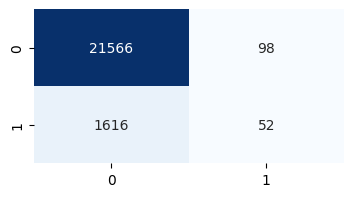

In [746]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report

train_accuracy = accuracy_score(y_train, prediccion_train_lr)
train_precision = precision_score(y_train, prediccion_train_lr)
train_recall = recall_score(y_train, prediccion_train_lr)
train_f1 = f1_score(y_train, prediccion_train_lr)
conf_matrix = confusion_matrix(y_train, prediccion_train_lr)

print("Metricas de Evaluación:")
print(f"Accuracy: {train_accuracy}")
print(f"Precision: {train_precision}")
print(f"Recall: {train_recall}")
print(f"F1 Score: {train_f1}")
print("Confusion Matrix:")
plt.figure(figsize=(4, 2))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

                Imagen_06: Métricas de Evaluación T=0.3

In [760]:
probabilidad_validacion_lr = model_train_lr.predict_proba(X_validacion)[:, 1]
validacion['probabilidad_validacion_lr'] = probabilidad_validacion_lr
prediccion_validacion_lr = np.where(probabilidad_validacion_lr >= 0.3, 1, 0)
validacion['prediccion_validacion_lr'] = prediccion_validacion_lr

validacion['grupo_validacion_lr'] = validacion['probabilidad_validacion_lr'].apply(asignar_grupo)
validacion['grupo_validacion_lr'].value_counts().sort_index()

T1    102
T2     58
T3    246
T4    256
T5    645
T6    566
T7    186
T8      9
Name: grupo_validacion_lr, dtype: int64

Metricas de Evaluación:
Accuracy: 0.926538659351963
Precision: 0.3466666666666667
Recall: 0.03117505995203837
F1 Score: 0.05720572057205721
Confusion Matrix:


<AxesSubplot: >

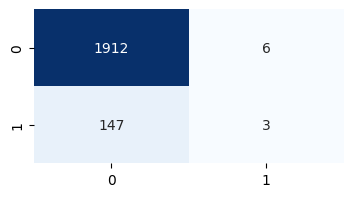

In [761]:
validacion_accuracy = accuracy_score(y_validacion, prediccion_validacion_lr)
validacion_precision = precision_score(y_validacion, prediccion_validacion_lr)
validacion_recall = recall_score(y_validacion, prediccion_validacion_lr)
validacion_f1 = f1_score(y_validacion, prediccion_validacion_lr)
conf_matrix = confusion_matrix(y_validacion, prediccion_validacion_lr)

print("Metricas de Evaluación:")
print(f"Accuracy: {train_accuracy}")
print(f"Precision: {train_precision}")
print(f"Recall: {train_recall}")
print(f"F1 Score: {train_f1}")
print("Confusion Matrix:")
plt.figure(figsize=(4, 2))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

            Imagen_07: Métricas de Evaluación  V=0.3

**Evaluación por Grupos**

In [762]:
df1_df2_['num_doc'].duplicated().sum()

318

In [763]:
df1_df2_lr = pd.concat([train, validacion], ignore_index=True)
duplicados_lr = df1_df2_lr[df1_df2_lr['num_doc'].duplicated(keep=False)]
df_grupos_lr = duplicados_lr.groupby('num_doc').agg({
    'grupo_train_lr': 'first',
    'grupo_validacion_lr': 'first'
}).reset_index()

df_grupos_lr['acc'] = df_grupos_lr['grupo_train_lr'] == df_grupos_lr['grupo_validacion_lr']
accuracy = df_grupos['acc'].mean()
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.43


In [691]:
df_grupos_lr[:10]

,num_doc,grupo_train_lr,grupo_validacion_lr,acc
0,104630908229,T6,T6,True
1,10627359005,T6,T6,True
2,111504450365,T7,T6,False
3,115062512307,T4,T4,True
4,119214748986,T4,T4,True
5,122109774016,T4,T1,False
6,124776742865,T8,T8,True
7,130768631561,T5,T5,True
8,131370404644,T3,T2,False
9,133176873743,T5,T5,True


                               Imagen_08: Evaluación por Grupos

### 3.2.2. KNN Clasificación

**Contrucción y Evaluación del modelo**

In [734]:
from sklearn.neighbors import KNeighborsClassifier

model_train_knn = KNeighborsClassifier(n_neighbors=3)
model_train_knn.fit(X_train, y_train)
prediccion_train_knn = model_train_knn.predict(X_train)
train['prediccion_train_knn'] = prediccion_train_knn

probabilidad_train_knn = model_train.predict_proba(X_train)[:, 1]
train['probabilidad_train_knn'] = probabilidad_train_knn
train['grupo_train_knn'] = train['probabilidad_train_knn'].apply(asignar_grupo)
train['grupo_train_knn'].value_counts().sort_index()

T1    19163
T8     4169
Name: grupo_train_knn, dtype: int64

Metricas de Evaluación:
Accuracy: 0.9387107834733414
Precision: 0.7195571955719557
Recall: 0.23381294964028776
F1 Score: 0.35294117647058826
Confusion Matrix:


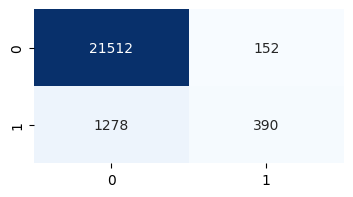

In [735]:
train_accuracy = accuracy_score(y_train, prediccion_train_knn)
train_precision = precision_score(y_train, prediccion_train_knn)
train_recall = recall_score(y_train, prediccion_train_knn)
train_f1 = f1_score(y_train, prediccion_train_knn)
conf_matrix = confusion_matrix(y_train, prediccion_train_knn)

print("Metricas de Evaluación:")
print(f"Accuracy: {train_accuracy}")
print(f"Precision: {train_precision}")
print(f"Recall: {train_recall}")
print(f"F1 Score: {train_f1}")
print("Confusion Matrix:")
plt.figure(figsize=(4, 2))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.show()

In [736]:
prediccion_validacion_knn = model_train_knn.predict(X_validacion)
validacion['prediccion_validacion_knn'] = prediccion_validacion_knn

probabilidad_validacion_knn = model_train_knn.predict_proba(X_validacion)[:, 1]
validacion['probabilidad_validacion_knn'] = probabilidad_validacion_knn

validacion['grupo_validacion_knn'] = validacion['probabilidad_validacion_knn'].apply(asignar_grupo)
validacion['grupo_validacion_knn'].value_counts().sort_index()

T1    1661
T8     407
Name: grupo_validacion_knn, dtype: int64

Metricas de Evaluación:
Accuracy: 0.9387107834733414
Precision: 0.7195571955719557
Recall: 0.23381294964028776
F1 Score: 0.35294117647058826
Confusion Matrix:


<AxesSubplot: >

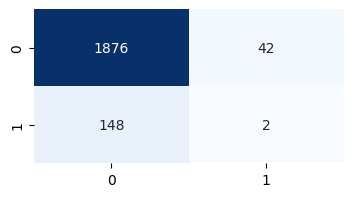

In [737]:
validacion_accuracy = accuracy_score(y_validacion, prediccion_validacion_knn)
validacion_precision = precision_score(y_validacion, prediccion_validacion_knn)
validacion_recall = recall_score(y_validacion, prediccion_validacion_knn)
validacion_f1 = f1_score(y_validacion, prediccion_validacion_knn)
conf_matrix = confusion_matrix(y_validacion, prediccion_validacion_knn)

print("Metricas de Evaluación:")
print(f"Accuracy: {train_accuracy}")
print(f"Precision: {train_precision}")
print(f"Recall: {train_recall}")
print(f"F1 Score: {train_f1}")
print("Confusion Matrix:")
plt.figure(figsize=(4, 2))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

**Evaluación por Grupos**

In [738]:
df1_df2_knn['num_doc'].duplicated().sum()

318

In [739]:
df1_df2_knn = pd.concat([train, validacion], ignore_index=True)
duplicados_knn = df1_df2_knn[df1_df2_knn['num_doc'].duplicated(keep=False)]
df_grupos_knn = duplicados_knn.groupby('num_doc').agg({
    'grupo_train_knn': 'first',
    'grupo_validacion_knn': 'first'
}).reset_index()

df_grupos_knn['acc'] = df_grupos_knn['grupo_train_knn'] == df_grupos_knn['grupo_validacion_knn']
accuracy = df_grupos_knn['acc'].mean()
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.83


In [740]:
df_grupos_knn[:10]

,num_doc,grupo_train_knn,grupo_validacion_knn,acc
0,104630908229,T1,T1,True
1,10627359005,T1,T1,True
2,111504450365,T1,T1,True
3,115062512307,T1,T1,True
4,119214748986,T8,T1,False
5,122109774016,T1,T8,False
6,124776742865,T8,T8,True
7,130768631561,T1,T1,True
8,131370404644,T1,T1,True
9,133176873743,T1,T1,True


In [741]:
df_grupos_knn[['grupo_train_knn', 'grupo_validacion_knn']].value_counts()

grupo_train_knn  grupo_validacion_knn
T1               T1                      234
T8               T8                       31
                 T1                       27
T1               T8                       26
dtype: int64

**Aplicar Modelo Ganador**

In [764]:
prediccion_final_ganador = model_train_lr.predict(X_prueba)
prueba['prediccion_final_ganador'] = prediccion_final_ganador

probabilidad_final_ganador = model_train_lr.predict_proba(X_prueba)[:, 1]
prueba['probabilidad_final_ganador'] = probabilidad_final_ganador

prueba['grupo_riesgo'] = prueba['probabilidad_final_ganador'].apply(asignar_grupo)
prueba['grupo_riesgo'].value_counts().sort_index()

T1     413
T2     214
T3     734
T4     876
T5    1739
T6    1392
T7     448
T8      73
Name: grupo_riesgo, dtype: int64

In [766]:
prueba.to_csv(r'base_prueba.csv')